<a href="https://colab.research.google.com/github/TaeminDA/portfolio/blob/main/regression/Tax_Rebate_and_Heterogeneous_Behavior_with_CI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bachelor Thesis Final with Deep Neural Network

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from timeit import default_timer as timer
from datetime import timedelta

## Data Preprocessing

### Import Data

Data: Tax Rebate 2008 from Consumer Expenditure Interview Survey

In [ ]:
df_2008 = pd.read_csv("/content/dataframe_2008_cluster.csv")
df_2008 = df_2008.drop(df_2008.columns[0],axis = 1)

In [ ]:
df_2008 = df_2008.drop(['c_1', 'c_2', 'c_3','k_1','k_2','k_3',"chadults","chchildren"],axis = 1)

In [ ]:
df_2008.shape

(17718, 20)

In [ ]:
df_2008.columns

Index(['age', 'income', 'adults', 'children', 'total_expenditure',
       'tax_rebate', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'housing_type_2', 'housing_type_4', 'housing_type_5'],
      dtype='object')

### Detect Outlier and Remove it

In [ ]:
from scipy import stats

In [ ]:
outlier_column = ["total_expenditure","income"]

In [ ]:
filtered_outlier = (np.abs(stats.zscore(df_2008[outlier_column])) < 3).all(axis=1)
df_2008 = df_2008[filtered_outlier]
df_2008 = df_2008.reset_index().drop(["index"],axis = 1)

In [ ]:
df_2008.shape

(17054, 20)

In [ ]:
#df_2008.to_csv("df_2008")

In [ ]:
df_2008

,age,income,adults,children,total_expenditure,tax_rebate,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,housing_type_2,housing_type_4,housing_type_5
0,74.0,15234.0,1,0,4118.5001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,58.0,60010.0,2,0,13801.4995,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,45.0,66134.2,2,3,8940.7496,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,49.5,60217.8,2,1,17512.7505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,46.0,122015.0,2,1,10071.9998,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17049,31.5,36640.0,2,3,7412.0330,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17050,56.0,32393.0,2,1,3794.0002,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17051,59.0,83095.8,4,0,17729.0003,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17052,78.0,8957.0,1,0,1814.7004,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


***

### Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
start = timer()
###
scaler = MinMaxScaler()


min_2008 = df_2008.min()
max_2008 = df_2008.max()

df_2008_normalized = scaler.fit_transform(df_2008)

df_2008_normalized = pd.DataFrame(df_2008_normalized)

df_2008_normalized.columns = df_2008.columns
###
end = timer()


print("It took ",timedelta(seconds=end-start), " to normalize the dataset")  

It took  0:00:00.015096  to normalize the dataset


### Divide into X and y

In [ ]:
X_2008 = df_2008_normalized.drop(["total_expenditure"], axis =1) 
y_2008 = df_2008_normalized["total_expenditure"]

In [ ]:
len(X_2008)

17054

### Splitting into Training, Validation and Test set

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
## 2008
# split dataset into Train and Validation
X_train_2008, X_test_2008, y_train_2008, y_test_2008 = train_test_split(
    X_2008, 
    y_2008, 
    test_size=0.2,  
    random_state=629) 

### Resampling

In [ ]:
num_subsets = 250

In [ ]:
for_resam_2008 = pd.concat([X_train_2008,y_train_2008], axis=1)

In [ ]:
X_subsets_train_2008 = []
y_subsets_train_2008 = []

for i in range(0,num_subsets):
    sb = for_resam_2008.sample(frac = 0.3,replace=True)

    Xsb = sb.drop(["total_expenditure"], axis =1)
    ysb = sb["total_expenditure"]

    X_subsets_train_2008.append(Xsb)
    y_subsets_train_2008.append(ysb)

## Deep Neural Network

In [ ]:
from tqdm import tqdm

In [ ]:
from tensorflow.keras import regularizers

### Training

In [ ]:
num_epoch = 1000

In [ ]:
print("Totally, there are ",len(X_subsets_train_2008), "training processes(# of subsets)")
print("=========================================================")
print("\n")

start = timer()

sub_histories_2008 = []
trained_model_2008 = []

for i in tqdm(range(0,len(X_subsets_train_2008))):

  # model
    model = keras.Sequential([ 
            keras.layers.Dense(16,activation = "relu", kernel_regularizer=regularizers.l2(l2=1e-4)),  
            keras.layers.Dense(8,activation = "relu", kernel_regularizer=regularizers.l2(l2=1e-4)),
            keras.layers.Dense(1)
        ])
  

  # compile
    adam_opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=adam_opt, metrics=['mse'])



  # history
    history = model.fit(X_subsets_train_2008[i],
                    y_subsets_train_2008[i],
                    batch_size=256,
                    epochs=num_epoch,
                    verbose=0,
                    validation_split = 0.2)
                    #validation_data=(X_valid_2008, y_valid_2008))

# save
    trained_model_2008.append(model)
    sub_histories_2008.append(history)

end = timer()
print("\n")
print("=========================================================")
print("It took ",timedelta(seconds=end-start), " to train the whole models")

  0%|          | 0/250 [00:00<?, ?it/s]

Totally, there are  250 training processes(# of subsets)




100%|██████████| 250/250 [4:00:37<00:00, 57.75s/it]



It took  4:00:37.063286  to train the whole models


### Testing

In [ ]:
print("=========================================================")
print("\n")

start = timer()

yhat_list_2008 = []

for i in tqdm(range(0,len(trained_model_2008))):
    yhat_2008 = np.squeeze(trained_model_2008[i].predict(X_test_2008)) # Predict X_test
    yhat_list_2008.append(yhat_2008)


yhat_df_2008 = pd.DataFrame(yhat_list_2008).transpose()

yhat_df_2008_original = (yhat_df_2008 * (max_2008["total_expenditure"] - min_2008["total_expenditure"])) + min_2008["total_expenditure"]
yhat_mean_2008_original = np.mean(yhat_df_2008_original,axis = 1)
yhat_std_2008_original = np.std(yhat_df_2008_original,axis = 1)

y_test_2008_original = (y_test_2008 * (max_2008["total_expenditure"] - min_2008["total_expenditure"])) + min_2008["total_expenditure"]
y_test_2008_index = y_test_2008_original.reset_index().pop("index")
y_test_2008_original = y_test_2008_original.reset_index().drop("index",axis = 1)
residuel_2008_original = yhat_df_2008_original.sub(y_test_2008_original["total_expenditure"], axis=0)


end = timer()

print("\n")
print("=========================================================")
print("It took ",timedelta(seconds=end-start), " to test the whole models")

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:46<00:00,  5.36it/s]




It took  0:00:47.103133  to test the whole models


### Histroy

In [ ]:
 # loss
list_loss_2008 = []
for i in range(0,len(sub_histories_2008)):
    loss_2008 = np.array(sub_histories_2008[i].history["loss"])
    list_loss_2008.append(loss_2008)
        
loss_df_2008 = pd.DataFrame(list_loss_2008).transpose()

list_val_loss_2008 = []
for i in range(0,len(sub_histories_2008)):
    val_loss_2008 = np.array(sub_histories_2008[i].history["val_loss"])
    list_val_loss_2008.append(val_loss_2008)
        
val_loss_df_2008 = pd.DataFrame(list_val_loss_2008).transpose()

In [ ]:
mean_loss_2008 = np.mean(loss_df_2008,axis=1)
mean_val_loss_2008 = np.mean(val_loss_df_2008, axis = 1)

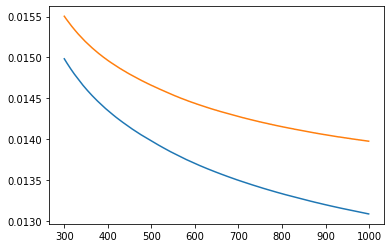

In [ ]:
plt.plot(mean_loss_2008[300:])
plt.plot(mean_val_loss_2008[300:])

In [ ]:
 import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("total_expenditure_2008", "predicted total_expenditure_2008"))



fig.add_trace(go.Histogram(x=y_test_2008_original["total_expenditure"],
                           xbins=dict(size=1000),marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Histogram(x=yhat_mean_2008_original,
                           xbins=dict(size=1000),marker_color='#1f77b4'), row=1, col=2)
#fig.add_trace(go.Histogram(x=res_2001.predict(X_test_2001),
#                           xbins=dict(size=1000), marker_color='#1f77b4'), row=1, col=2)

fig.update_layout(title_text="2008 Prediction Linear Regression (Test set Comparison)", height=400, showlegend=False,
                  bargap=0.1,
                  bargroupgap=0.1)

### MSE and RMSE with test set

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
MSE_2008 = mean_squared_error(y_test_2008_original["total_expenditure"],yhat_mean_2008_original)

In [ ]:
RMSE_2008 = np.sqrt(MSE_2008)

In [ ]:
print("RMSE_2008: ",RMSE_2008)

RMSE_2008:  4713.877900654876


***

## Visualization

In [ ]:
num_ob = 200

In [ ]:
X_income_2008_original = (X_test_2008["income"] * (max_2008["income"] - min_2008["income"])) + min_2008["income"]

***

## Giving everyone Tax Rebate dollar additionally

In [ ]:
X_2008_tr = X_2008.copy()
y_2008_tr = y_2008.copy()

In [ ]:
X_2008_tr.tax_rebate = 0

In [ ]:
yhat_list_2008_tr = []

for i in tqdm(range(0,len(trained_model_2008))):
    yhat_2008_tr = np.squeeze(trained_model_2008[i].predict(X_2008_tr))
    yhat_list_2008_tr.append(yhat_2008_tr)


yhat_df_2008_tr = pd.DataFrame(yhat_list_2008_tr).transpose()
yhat_df_2008_original_tr = (yhat_df_2008_tr * (max_2008["total_expenditure"] - min_2008["total_expenditure"])) + min_2008["total_expenditure"]

y_2008_original_tr = (y_2008_tr * (max_2008["total_expenditure"] - min_2008["total_expenditure"])) + min_2008["total_expenditure"]

yhat_mean_2008_original_tr = np.mean(yhat_df_2008_original_tr,axis = 1)
yhat_std_2008_original_tr = np.std(yhat_df_2008_original_tr,axis = 1)
#residuel_2008_original_tr = yhat_mean_2008_original_tr.sub(y_2008_original_tr, axis=0)

100%|██████████| 250/250 [02:03<00:00,  2.03it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



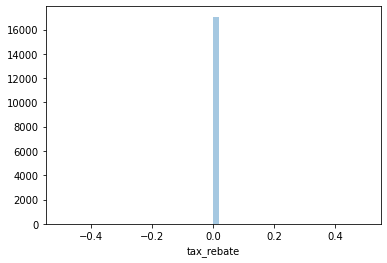

In [ ]:
sns.distplot(X_2008_tr.tax_rebate, kde = False)

#### give 600

In [ ]:
amount_of_tr = 600

**Watch out!! don't substract min twice!!**

In [ ]:
#scaled_tr_2008 = (amount_of_tr) / (max_2008["income"] - min_2008["income"])

scaled_tr_2008 = (amount_of_tr) / (max_2008["tax_rebate"] - min_2008["tax_rebate"])

In [ ]:
#X_2008_tr["income"] = X_2008_tr["income"] + scaled_tr_2008

X_2008_tr["tax_rebate"] = X_2008_tr["tax_rebate"] + scaled_tr_2008

In [ ]:
X_2008_tr.tax_rebate

0        0.166667
1        0.166667
2        0.166667
3        0.166667
4        0.166667
           ...   
17049    0.166667
17050    0.166667
17051    0.166667
17052    0.166667
17053    0.166667
Name: tax_rebate, Length: 17054, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



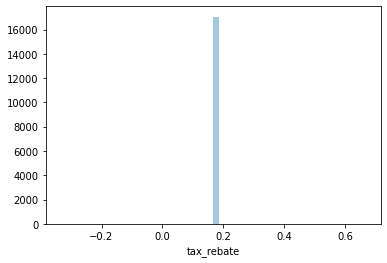

In [ ]:
sns.distplot(X_2008_tr.tax_rebate, kde = False)

In [ ]:
yhat_list_2008_tr_after = []

for i in tqdm(range(0,len(trained_model_2008))):
    yhat_2008_tr_after = np.squeeze(trained_model_2008[i].predict(X_2008_tr))
    yhat_list_2008_tr_after.append(yhat_2008_tr_after)


yhat_df_2008_tr_after = pd.DataFrame(yhat_list_2008_tr_after).transpose()
yhat_df_2008_original_tr_after = (yhat_df_2008_tr_after * (max_2008["total_expenditure"] - min_2008["total_expenditure"])) + min_2008["total_expenditure"]

yhat_mean_2008_original_tr_after = np.mean(yhat_df_2008_original_tr_after,axis = 1)
yhat_std_2008_original_tr_after = np.std(yhat_df_2008_original_tr_after,axis = 1)

100%|██████████| 250/250 [02:03<00:00,  2.03it/s]


In [ ]:
X_income_2008_original_tr = (X_2008_tr["income"] * (max_2008["income"] - min_2008["income"])) + min_2008["income"]

In [ ]:
num_ob = 200

In [ ]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=X_income_2008_original_tr[:num_ob],
                         y=yhat_mean_2008_original_tr[:num_ob],
                         marker_symbol = "circle-dot",
                         mode='markers',
                         marker=dict(color="royalblue",opacity=0.5, size = 10,
                                     line=dict(color='black', width=1)),
                         name='Before Tax Rebate'))

fig.add_trace(go.Scatter(x=X_income_2008_original_tr[:num_ob],
                         y=yhat_mean_2008_original_tr_after[:num_ob],
                         marker_symbol = "x-dot",
                         mode='markers',
                         marker=dict(color="firebrick",opacity=0.5, size = 10,
                                     line=dict(color='black', width=1)),
                         name='After Tax Rebate'))

#fig.add_shape(type='line',
#                x0=upper_income_2008,
#                y0=0,
#                x1=upper_income_2008,
#                y1=30000,
#                line=dict(color='red',dash="dot")
#)
#fig.add_shape(type='line',
#                x0=lower_income_2008,
#                y0=0,
#                x1=lower_income_2008,
#                y1=30000,
#                line=dict(color='blue',dash="dot")
#)

fig.update_layout(title='2008 Effect of Tax Rebate({0})'.format(amount_of_tr),
                  xaxis_title='Income',
                  yaxis_title='Predicted Expenditure',
                  template= "plotly_white")

fig.show()

# might have to increase Income not Tax_rebate

The difference between increasing Income and Tax Rebate is significant

Individual MPC Confidence Interval

In [ ]:
# amount_of_tr = 600
# yhat_df_2001_original_tr
# yhat_df_2008_original_tr
# yhat_df_2001_original_tr_after
# yhat_df_2008_original_tr_after

In [ ]:
mpc_2008_df = (yhat_df_2008_original_tr_after - yhat_df_2008_original_tr)/amount_of_tr

In [ ]:
mpc_2008_mean = np.mean(mpc_2008_df,axis = 1)
mpc_2008_std = np.std(mpc_2008_df,axis = 1)

In [ ]:
mpc_2008_ci = pd.DataFrame({'mean' : mpc_2008_mean,'ci_plus':mpc_2008_mean + (1.96*mpc_2008_std)/np.sqrt(num_subsets),
                            'ci_minus':mpc_2008_mean - (1.96*mpc_2008_std)/np.sqrt(num_subsets)})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



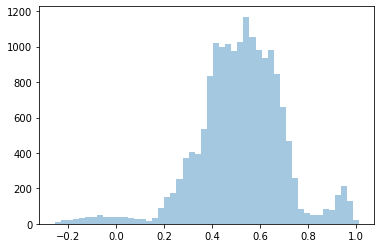

In [ ]:
sns.distplot(mpc_2008_mean, kde = False)

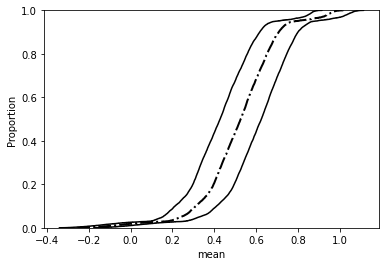

In [ ]:
sns.ecdfplot(mpc_2008_ci["mean"], color = "black", linestyle = "-.", linewidth = 2)
sns.ecdfplot(mpc_2008_ci["ci_plus"], color = "black")
sns.ecdfplot(mpc_2008_ci["ci_minus"], color = "black")

In [ ]:
n_CI = 100

Text(0.5, 1.0, 'MPC Confidence Interval 2008')

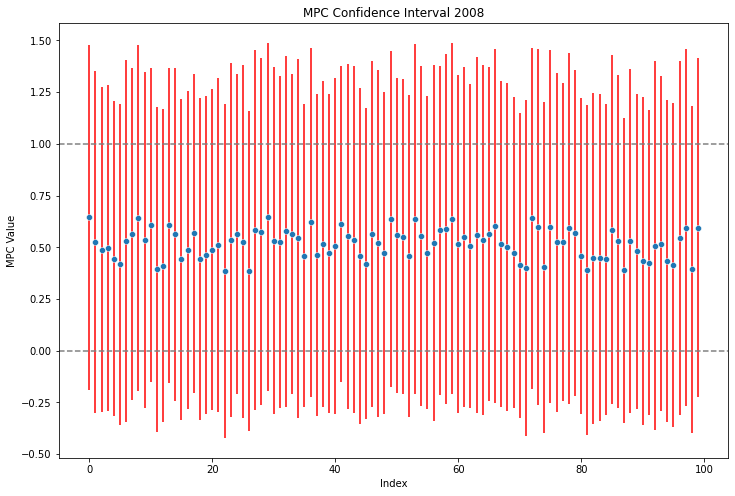

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(x=mpc_2008_ci[:n_CI].index, y="mean", data=mpc_2008_ci[:n_CI], ax = ax)
ax.errorbar(x=mpc_2008_ci[:n_CI].index, y="mean", yerr=mpc_2008_std[:n_CI], data=mpc_2008_ci[:n_CI],
    ecolor="red", fmt=' ', zorder=-1)

ax.axhline(1, color='grey', linestyle='--')
ax.axhline(0, color='grey', linestyle='--')

plt.xlabel("Index")
plt.ylabel("MPC Value")
plt.title("MPC Confidence Interval 2008")

In [ ]:
# amount_of_tr = 600
#from google.colab import  drive
#drive.mount('/drive')

In [ ]:
#yhat_df_2008_original_tr.to_csv('yhat_df_2008_original_tr.csv')
#yhat_df_2008_original_tr_after.to_csv('yhat_df_2008_original_tr_after.csv')
#yhat_df_2008_original.to_csv('yhat_df_2008_original.csv')
#y_test_2008_original.to_csv('y_test_2008_original.csv')

In [ ]:
#yhat_df_2008_original_tr.to_csv('600.csv')
#yhat_df_2008_original_tr_after.to_csv('600_after.csv')